In [1]:
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import networkx as nx

### Load data

In [2]:
# If RAM is limited, set total_rows = 10000 or 100000; otherwise, set total_rows = None
total_rows = 100000 #None
date = pd.read_csv('data/train_date.csv.zip', index_col=0, nrows=total_rows)

# Drop rows and columns if they are redundant
date.dropna(axis=0, how='all', inplace=True)
date.dropna(axis=1, how='all', inplace=True)

# Load labels
response = pd.read_csv('data/train_numeric.csv.zip', index_col=0, 
                       usecols=[0, 969], nrows=total_rows)

### Restructure columns
Each column of `date` records a time stamp in the production line and tracks flows of parts. The columns follow a name convention of `Line_Station_Feature`. 

The structure of production line, station, and feature is hierarchical, i.e., there is no feature belongs to two stations, and no station belongs to two lines. So we can restructure the columns.

In [3]:
# Extract station and feature names, and build a new pandas MultiIndex object
new_columns = pd.MultiIndex.from_tuples([tuple([int(a[1:]) 
                                          for a in x[3:].split('_')])
                                          for x in date.columns], 
                                          names=['station', 'feature'])
date.columns = new_columns

In [4]:
# Extract station names
stations = sorted([x for x in date.columns.levels[0]])

In [5]:
# The earliest recorded time of a part going into a station
# Notice that now we have dropped features (recorded time stamps) and only cares about stations
date_station0 = pd.DataFrame({i: date[i].apply(min, axis=1) 
                            for i in stations})

In [6]:
# Create two series recording if a part is positive (failure) or negative (not failure)
response_p = response.Response.apply(lambda x: 'p' if x==1 else np.nan)
response_n = response.Response.apply(lambda x: 'n' if x==0 else np.nan)

In [7]:
# Add the two series into `date_station0`
date_station0['p'] = response_p
date_station0['n'] = response_n

In [8]:
# Obtain indexes of positive and negative
neg_idx = date_station0[date_station0.n=='n'].index
pos_idx = date_station0[date_station0.p=='p'].index

In [9]:
# Calculate positive probabilities of each station
# We add two dummy stations into `node_weights` representing the positive and negative labels

# date_station1 = date_station0.copy()
# date_station1.n = date_station1.n.apply(lambda x: 1 if x=='n' else 0)
# date_station1.p = date_station1.p.apply(lambda x: 1 if x=='p' else 0)


node_weights = date_station0[date_station0.p=='p'].notna().sum(axis=0)/date_station0.notna().sum(axis=0)
node_weights = node_weights.to_dict()

In [10]:
# Obtain the flow of stations for each part by dropping NaNs in each row of `date_station0` 
# `date_station` is a pandas series containing the list of stations, including positive and negative labels
date_station = date_station0.apply(lambda x: x.dropna().index.tolist(), axis=1)

In [11]:
# Convert station flows to lists of station transitions for each part
date_station_list = date_station.apply(lambda x: [(x[i], x[i+1]) for i in range(len(x)-1)]).values.tolist()
# Obtain station transitions for positive samples
date_station_list_pos = date_station.loc[pos_idx].apply(lambda x: [(x[i], x[i+1]) for i in range(len(x)-1)]).values.tolist()
# Obtain station transitions for negative samples
date_station_list_neg = date_station.loc[neg_idx].apply(lambda x: [(x[i], x[i+1]) for i in range(len(x)-1)]).values.tolist()

# convert list of lists to one list, and then to series 
date_station_list = [x for a in date_station_list for x in a]
date_station_list_pos = [x for a in date_station_list_pos for x in a]
date_station_list_neg = [x for a in date_station_list_neg for x in a]

date_station_list = pd.Series(date_station_list)
date_station_list_pos = pd.Series(date_station_list_pos)
date_station_list_neg = pd.Series(date_station_list_neg)

In [12]:
# Calculate value counts (histogram) of each transition
edges = date_station_list.value_counts().to_dict()
edges_pos = date_station_list_pos.value_counts().to_dict()
edges_neg = date_station_list_neg.value_counts().to_dict()

# Calculate positive (failure) rate for each transition
edges_pos_rate = {k: edges_pos[k]/edges[k] for k in edges_pos.keys()}

In [13]:
# Also include the dummy positive and negative stations into the station list
stations.extend(['n', 'p'])

### Visualization
Use `networkx` to create a weighted directed graph, whose nodes and edges represent stations and station transitions, respectively. Node and edge weights are the corresponding positive rates.

Use `Plotly` to create figures for interactive visualization.

In [14]:
# Create a graph with `networkx`
G = nx.Graph()
G.add_nodes_from(stations)
G.add_edges_from(edges.keys())

In [15]:
# Assign positions to each network node according to work flows.
# Manual adjustment is required here for good visualization.

# Initially, use spring layout of node positions, but not necessary later.
pos = nx.spring_layout(G)
for n, p in pos.items():
    G.node[n]['pos'] = p
    
G.node[0]['pos'] = [0, 1]
G.node[1]['pos'] = [1, 1]
G.node[2]['pos'] = [2, 2]
G.node[3]['pos'] = [2, 0]
G.node[4]['pos'] = [3, 2]
G.node[5]['pos'] = [3, 0]
G.node[6]['pos'] = [4, 2]
G.node[7]['pos'] = [4, 0]
G.node[8]['pos'] = [5, 1]
G.node[9]['pos'] = [6, 2.5]
G.node[10]['pos'] = [6, 1]
G.node[11]['pos'] = [6, -0.5]

G.node[12]['pos'] = [0, -3]
G.node[13]['pos'] = [1, -3]
G.node[14]['pos'] = [2, -2]
G.node[15]['pos'] = [2, -4]
G.node[16]['pos'] = [3, -2]
G.node[17]['pos'] = [3, -4]
G.node[18]['pos'] = [4, -2]
G.node[19]['pos'] = [4, -4]
G.node[20]['pos'] = [5, -3]
G.node[21]['pos'] = [6, -1.5]
G.node[22]['pos'] = [6, -3]
G.node[23]['pos'] = [6, -4.5]

G.node[24]['pos'] = [5, -6]
G.node[25]['pos'] = [5, -7]
G.node[26]['pos'] = [7, -6]
G.node[27]['pos'] = [7, -7]
G.node[28]['pos'] = [7, -8]


G.node[29]['pos'] = [8, -1]
G.node[30]['pos'] = [9, -1]
G.node[31]['pos'] = [10, -2.5]
G.node[32]['pos'] = [11, 0]
G.node[33]['pos'] = [11, -2]
G.node[34]['pos'] = [12, -2]
G.node[35]['pos'] = [13, 0]
G.node[36]['pos'] = [13, -2]
G.node[37]['pos'] = [14, -1]
G.node[38]['pos'] = [15, -1]

G.node[39]['pos'] = [8, -4]
G.node[40]['pos'] = [9, -4]
G.node[41]['pos'] = [10, -4]
G.node[43]['pos'] = [11, -3]
G.node[44]['pos'] = [11, -5]
G.node[45]['pos'] = [12, -4]
G.node[47]['pos'] = [13, -4]
G.node[48]['pos'] = [14, -4]
G.node[49]['pos'] = [15, -3]
G.node[50]['pos'] = [15, -5]
G.node[51]['pos'] = [16, -4]

G.node['n']['pos'] = [18, 1]
G.node['p']['pos'] = [18, -4]

In [16]:
# Create traces for plotly figure illustrating work flows
edge_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    line=dict(width=1,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]
    edge_trace['text'].append(edges[edge]/len(date))

node_trace = go.Scatter(
x=[],
y=[],
text=[],
hovertext=[],
mode='markers+text',
hoverinfo='hovertext',
textposition='bottom',
marker=dict(
    showscale=False,
    # colorscale options
    # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
    # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
    colorscale='YIGnBu',
    reversescale=True,
    color=[],
    size=10,
#     colorbar=dict(
#         thickness=15,
#         title='Node Connections',
#         xanchor='left',
#         titleside='right'
#     ),
    line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['text'].append(node)
    node_trace['hovertext'].append(node_weights[node])


In [17]:
# Plot the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Bosch Production Line',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')


In [18]:
# Error probabilities of stations
trace1 = go.Scatter(
    x = list(node_weights.keys())[:-2],
    y = list(node_weights.values())[:-2],
    name='Error Probability'
)

trace2 = go.Scatter(
    x = list(node_weights.keys())[:-2],
    y = np.median(list(node_weights.values())[:-2])*np.ones(52),
    name='Median Error Probability'
)

fig = go.Figure(data=[trace1, trace2],
                layout=go.Layout(title='Error Probability',
                                xaxis=dict(title='Station', range=[-1, 52]),
                                yaxis=dict(title='Probability', range=[0, 0.05])))

py.iplot(fig)

In [44]:
# Error probabilities of station transitions
edges_pos_rate_sorted = sorted(edges_pos_rate.items(), key=lambda x: x[1], reverse=True)

trace_pos_rate = go.Scatter(
    x = [],
    y = [], 
    mode='lines',
    hovertext=[],
    hoverinfo='hovertext'
)

for n, x in enumerate(edges_pos_rate_sorted):
    if n>2:
        trace_pos_rate['x'].append(n)
        trace_pos_rate['y'].append(x[1])
        trace_pos_rate['hovertext'].append(x[0].__str__())
        
# Absolute error numbers of station transitions
edges_pos_sorted = sorted(edges_pos.items(), key=lambda x: x[1], reverse=True)

trace_pos_count = go.Scatter(
    x = [],
    y = [], 
    mode='lines',
    hovertext=[],
    hoverinfo='hovertext',
    yaxis='y2'
)

for n, x in enumerate(edges_pos_sorted):
    if n>2:
        trace_pos_count['x'].append(n)
        trace_pos_count['y'].append(x[1])
        trace_pos_count['hovertext'].append(x[0].__str__())
        
fig = go.Figure(data=[trace_pos_rate, trace_pos_count], 
                layout=go.Layout(
                legend=dict(orientation="h"),
                title='<br>Transition Error Probability',
                xaxis=dict(range=[0, len(edges_pos_rate_sorted)+5], title='Transition Index'),
                yaxis=dict(range=[0, 0.6], title='Probability', showgrid=False),
                yaxis2=dict(range=[0, edges_pos_sorted[0][1]+10], title='Count',
                           overlaying='y', side='right', showgrid=False, showline=True)
                ))
        
py.iplot(fig)

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per day. If you need to raise your daily limit, consider upgrading to a Student or Personal Plan
see: https://plot.ly/products/cloud

In [20]:
# Amount of data used in visualization
# More data will be more accurate, and results may change as well.
len(date)

99950

In [37]:
edges_pos_sorted = sorted(edges_pos.items(), key=lambda x: x[1], reverse=True)

trace_pos_rate = go.Scatter(
    x = [],
    y = [], 
    mode='lines',
    hovertext=[],
    hoverinfo='hovertext'
)

for n, x in enumerate(edges_pos_sorted):
    if n>2:
        trace_pos_rate['x'].append(n)
        trace_pos_rate['y'].append(x[1])
        trace_pos_rate['hovertext'].append(x[0].__str__())
        
fig = go.Figure(data=[trace_pos_rate], 
                layout=go.Layout(
                title='<br>Transition Error Probability',
                xaxis=dict(range=[0, len(edges_pos_sorted)+5], title='Transition Index'),
                yaxis=dict(range=[0, edges_pos_sorted[0][1]+10], title='Probability')
                ))
        
py.iplot(fig)

In [61]:
edges_pos_combine = {k: (edges_pos[k], edges_pos_rate[k]) for k in edges_pos.keys()}
edges_name, edges_value = zip(*edges_pos_combine.items())
edges_name = list(edges_name)
edges_value = list(edges_value)
x, y = zip(*edges_value)
x, y = list(x), list(y)

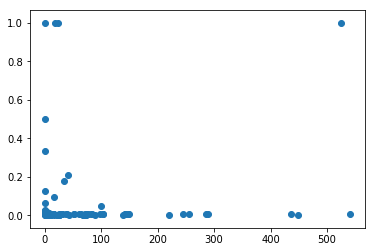

In [80]:
fig, ax = plt.subplots()
ax.scatter(x, y)

#for i, txt in enumerate(edges_name):
#    ax.annotate(txt, (x[i],y[i]))

#ax.set_xlim([-0, 100])
#ax.set_ylim([0.9, 1.05])